In [1]:
import sys
from unstructured.partition.pdf import partition_pdf

/Users/pablo.vizan/Projects/documesh/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

pdf_folder_path = "."
pdf_file_name = "787_chapter_2_sample.pdf"

raw_pdf_elements = partition_pdf(
    filename=pdf_file_name,                                # mandatory
    strategy="hi_res",                                     # mandatory to use ``hi_res`` strategy
    extract_images_in_pdf=True,                            # mandatory to set as ``True``
    extract_image_block_types=["Image", "Table"],          # optional
    extract_image_block_to_payload=False,                  # optional
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=pdf_folder_path,
)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [4]:
from langchain_text_splitters import CharacterTextSplitter

In [5]:
raw_pdf_elements

In [6]:
# Categorize extracted elements from a PDF into tables and texts.
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

# Optional: Enforce a specific token size for texts
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=10000, chunk_overlap=0
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

In [7]:
raw_pdf_elements[0].text

'2.0 AIRPLANE DESCRIPTION\n\n2.1 GENERAL CHARACTERISTICS\n\nMaximum Design Taxi Weight (MTW). Maximum weight for ground maneuver as limited by aircraft strength and airworthiness requirements. (It includes weight of taxi and run-up fuel.)\n\nMaximum Design Takeoff Weight (MTOW). Maximum weight for takeoff as limited by aircraft strength and airworthiness requirements. (This is the maximum weight at start of the takeoff run.)\n\nMaximum Design Landing Weight (MLW). Maximum weight for landing as limited by aircraft strength and airworthiness requirements.\n\nMaximum Design Zero Fuel Weight (MZFW). Maximum weight allowed before usable fuel and other specified usable agents must be loaded in defined sections of the aircraft as limited by strength and airworthiness requirements.\n\nOperating Empty Weight (OEW). Weight of structure, powerplant, furnishing systems, unusable fuel and other unusable propulsion agents, and other items of equipment that are considered an integral part of a partic

In [8]:
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_google_vertexai import (
    ChatVertexAI,
    VectorSearchVectorStore,
    VertexAI,
    VertexAIEmbeddings,
)
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser



MODEL_NAME = "gemini-2.0-flash"
GEMINI_OUTPUT_TOKEN_LIMIT = 8192

EMBEDDING_MODEL_NAME = "text-embedding-005"
EMBEDDING_TOKEN_LIMIT = 2048

TOKEN_LIMIT = min(GEMINI_OUTPUT_TOKEN_LIMIT, EMBEDDING_TOKEN_LIMIT)

In [ ]:
# Generate summaries of text elements


def generate_text_summaries(
    texts: list[str], tables: list[str], summarize_texts: bool = False
) -> tuple[list, list]:
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = PromptTemplate.from_template(prompt_text)
    empty_response = RunnableLambda(
        lambda x: AIMessage(content="Error processing document")
    )
    # Text summary chain
    model = VertexAI(
        temperature=0, model_name=MODEL_NAME, max_output_tokens=TOKEN_LIMIT
    ).with_fallbacks([empty_response])
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts:
        if summarize_texts:
            text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})
        else:
            text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 1})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts, tables, summarize_texts=True
)
     

In [65]:
text_summaries

['Boeing 787-8 General Characteristics: Max Taxi Weight (503,500 lbs / 228,383 kg), Max Takeoff Weight (502,500 lbs / 227,930 kg), Max Landing Weight (380,000 lbs / 172,365 kg), Max Zero Fuel Weight (355,000 lbs / 161,025 kg), Seating Capacity (359 one-class, 242 mixed-class), Max Cargo Volume (4,826 cubic feet / 136.7 cubic meters), Usable Fuel (33,340 U.S. Gallons / 126,206 Liters / 223,378 lbs / 101,343 kg). Definitions of: Maximum Design Taxi Weight, Maximum Design Takeoff Weight, Maximum Design Landing Weight, Maximum Design Zero Fuel Weight, Operating Empty Weight, Maximum Structural Payload, Maximum Seating Capacity, Maximum Cargo Volume, and Usable Fuel.\n',
 'Boeing 787-9 and 787-10 general characteristics: max taxi weight, takeoff weight, landing weight, zero fuel weight, seating capacity (one class and mixed class), max cargo volume, usable fuel capacity. Notes on engine types, LD-3 container capacity, and fuel density.',
 'Boeing 787-8, 787-9, and 787-10 general dimensions 

In [87]:
import os
import base64

def encode_image(image_path: str) -> str:
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(model: ChatVertexAI, base64_image: str, prompt: str) -> str:
    """Make image summary"""
    msg = model.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{base64_image}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(path: str) -> tuple[list[str], list[str], list[str]]:
    """
    Generate summaries and base64 encoded strings for images. Also return the name of the file.
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with parsing images from a technical manual to text for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    
    You must give an exhaustive summary of the image. Drawings must be described in detail. The goal is that a person who cannot see the image can understand it fully from your description.
    If there are tables in the image, all elements of the table must be extracted.
    If there are graphs in the image, explain the findings in the graph, as well as the axes and labels.
    If there are text elements in the image, they must be extracted and summarized.
    If there are no text elements, tables, or graphs, just describe the image in detail.
    Retrieve always information corresponding to the model of the drawing and the title of the image.

    Do not return any introductory text, just return the summary of the image. Strip the response of any markdown formatting.
    """

    model = ChatVertexAI(model_name=MODEL_NAME, max_output_tokens=TOKEN_LIMIT)

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            base64_image = encode_image(os.path.join(path, img_file))
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(model, base64_image, prompt))

    return img_base64_list, image_summaries, sorted(os.listdir(path))


# Image summaries
img_base64_list, image_summaries, img_filepaths = generate_img_summaries("figures/")

In [123]:
from google.cloud import aiplatform
# Environment variables and configuration
PROJECT_ID = "hacker2025-team-5-dev"
BUCKET_NAME = "example_bucket_airbus"  # Replace with your GCS bucket name
LOCATION = "europe-west4"
GCS_BUCKET_URI = f"gs://{BUCKET_NAME}"

aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=GCS_BUCKET_URI)

# Get the MatchingEngineIndexEndpoint object
index_endpoint = aiplatform.MatchingEngineIndexEndpoint(
    index_endpoint_name="projects/246245275285/locations/europe-west4/indexEndpoints/8378120273978720256",
    project="246245275285",
    location="europe-west4",
)

# Load the index using its full resource name
index = aiplatform.MatchingEngineIndex(
    index_name="projects/246245275285/locations/europe-west4/indexes/673235367733755904"
)

In [124]:
# from google.cloud import aiplatform
# # Environment variables and configuration
# PROJECT_ID = "hacker2025-team-5-dev"
# BUCKET_NAME = "example_bucket_airbus"  # Replace with your GCS bucket name
# LOCATION = "europe-west4"
# GCS_BUCKET_URI = f"gs://{BUCKET_NAME}"

# aiplatform.init(project=PROJECT_ID, location=LOCATION, staging_bucket=GCS_BUCKET_URI)

In [125]:

# # https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/text-embeddings
DIMENSIONS = 768  # Dimensions output from text-embedding-005

# index = aiplatform.MatchingEngineIndex.create_tree_ah_index(
#     display_name="mm_rag_langchain_index",
#     dimensions=DIMENSIONS,
#     approximate_neighbors_count=150,
#     leaf_node_embedding_count=500,
#     leaf_nodes_to_search_percent=7,
#     description="Multimodal RAG LangChain Index",
#     index_update_method="STREAM_UPDATE",
# )
     

In [126]:

DEPLOYED_INDEX_ID = "mm_rag_langchain_index_endpoint"

# index_endpoint = aiplatform.MatchingEngineIndexEndpoint.create(
#     display_name=DEPLOYED_INDEX_ID,
#     description="Multimodal RAG LangChain Index Endpoint",
#     public_endpoint_enabled=True,
# )

In [127]:

# index_endpoint = index_endpoint.deploy_index(
#     index=index, deployed_index_id="mm_rag_langchain_deployed_index"
# )
index_endpoint.deployed_indexes

[id: "mm_rag_langchain_deployed_index"
index: "projects/246245275285/locations/europe-west4/indexes/673235367733755904"
create_time {
  seconds: 1750422958
  nanos: 177242000
}
index_sync_time {
  seconds: 1750770589
  nanos: 938680000
}
automatic_resources {
  min_replica_count: 2
  max_replica_count: 2
}
deployment_group: "default"
]

In [128]:


# The vectorstore to use to index the summaries
vectorstore = VectorSearchVectorStore.from_components(
    project_id=PROJECT_ID,
    region=LOCATION,
    gcs_bucket_name=BUCKET_NAME,
    index_id=index.name,
    endpoint_id=index_endpoint.name,
    embedding=VertexAIEmbeddings(model_name=EMBEDDING_MODEL_NAME),
    stream_update=True,
)

In [129]:

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore

docstore = InMemoryStore()

id_key = "doc_id"
# Create the multi-vector retriever
retriever_multi_vector_img = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key,
)

In [ ]:
from langchain_core.documents import Document
import uuid

# Raw Document Contents
doc_contents = []
doc_metadata = []
doc_ids = []

# Add texts
doc_contents.extend(texts)
for text in texts:
    # Generate a unique ID for each text, ensure it will be the same every time the code is ran
    doc_id = str(uuid.uuid4())
    doc_ids.append(doc_id)
    doc_metadata.append({"id_key": doc_id, "type": "text", "file": pdf_file_name})

# Add tables
doc_contents.extend(tables)
for table in tables:
    # Generate a unique ID for each table
    doc_id = str(uuid.uuid4())
    doc_ids.append(doc_id)
    doc_metadata.append({"id_key": doc_id, "type": "table", "file": pdf_file_name})

# Add images
doc_contents.extend(img_base64_list)
for img_base64, img_path in zip(img_base64_list, img_filepaths):
    # Generate a unique ID for each table
    doc_id = str(uuid.uuid4())
    doc_ids.append(doc_id)
    doc_metadata.append({"id_key": doc_id, "type": "image", "file": pdf_file_name, "image_path": img_path})

summary_docs = [
    Document(page_content=s, metadata=doc_metadata[i])
    for i, s in enumerate(text_summaries + table_summaries + image_summaries)
]


retriever_multi_vector_img.docstore.mset(list(zip(doc_ids, doc_contents)))

# If using Vertex AI Vector Search, this will take a while to complete.
# You can cancel this cell and continue later.
retriever_multi_vector_img.vectorstore.add_documents(summary_docs)

Upserting datapoints MatchingEngineIndex index: projects/246245275285/locations/europe-west4/indexes/673235367733755904
MatchingEngineIndex index Upserted datapoints. Resource name: projects/246245275285/locations/europe-west4/indexes/673235367733755904


['4aefb366-43f0-4645-8f77-f390a61df43d',
 '0b9275c1-f64b-4d1e-bfa5-315e41899575',
 '3990a86e-ab0b-4911-a00b-9856a73d4b6c',
 'bcf76452-c5a8-4363-8491-f3b67112922c',
 'aa9ba75a-8186-46d0-8434-c280a11dc913',
 'e414429c-84b2-4c7a-8c3d-a741405a42b5',
 '0c40a004-282f-46d6-99ca-8111ba5008bb',
 '786100f7-1e7a-4892-8195-50f3d464d840',
 'ee1f8d41-a6ab-4c17-8278-969ce71b7baf',
 'ae70de97-0b44-4267-bd08-5b26bf9dc627',
 'ec8d9974-5097-4a1d-b00e-fb6c636a106d',
 '87fae9a1-4878-4937-b53e-6ed1f6a1f5cb',
 '3709bd0c-8fde-4aa9-80c8-239025feab7e',
 'fb236ae4-d7ae-4633-b52f-13e0907bfc93',
 '22703d67-3e43-44ea-bb07-b77f90ced420',
 'ba099fb2-7c05-4aa9-8aca-47d591d9156f',
 'c993d2bd-2791-4a92-9ba9-6764b808dc90',
 '65f5bd24-b9c0-4531-9d24-b7f873045318',
 'b8ada8a3-fd17-492b-9999-12e9845de04a',
 '4fcb65c5-08f1-4fdc-bf6e-f17cab2cc3b7',
 '823a2143-b6d1-4c8f-8756-d5ea8f195c20',
 'ec6a1915-f4b8-4391-bac6-367e9a974be6',
 'd208855e-6f70-4658-ae0f-727e845d163f']

In [131]:
import re
import base64

def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = [
        {
            "type": "text",
            "text": (
                "You are a technical expert in aircraft egnineering and procedures.\n"
                "You will be given a mix of text, tables, and image(s) usually of charts or graphs.\n"
                "You will be given a question from the user, and you must answer it using the provided context.\n"
                "You must use the context to answer the question, and you must not make up any information.\n"
                "If you do not know the answer, you must say that you do not know.\n"
                f"User-provided question: {data_dict['question']}\n\n"
                "Text and / or tables:\n"
                f"{formatted_texts}"
            ),
        }
    ]

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            messages.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )
    return [HumanMessage(content=messages)]


# Create RAG chain
chain_multimodal_rag = (
    {
        "context": retriever_multi_vector_img | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(img_prompt_func)
    | ChatVertexAI(
        temperature=0,
        model_name=MODEL_NAME,
        max_output_tokens=TOKEN_LIMIT,
    )  # Multi-modal LLM
    | StrOutputParser()
)
     

## Test queries

In [132]:
query = "What are all the general characteristics of boeing 787-8?"

result = chain_multimodal_rag.invoke(query)

Markdown(result)

Here are the general characteristics of the Boeing 787-8, according to the provided document:

*   **Maximum Design Taxi Weight:** 503,500 pounds (228,383 kilograms)
*   **Maximum Design Takeoff Weight:** 502,500 pounds (227,930 kilograms)
*   **Maximum Design Landing Weight:** 380,000 pounds (172,365 kilograms)
*   **Maximum Design Zero Fuel Weight:** 355,000 pounds (161,025 kilograms)
*   **Seating Capacity:**
    *   One Class (All-Economy): 359 seats (FAA exit limit = 381 seats)
    *   Mixed Class: 242 seats (24 Business Class, 218 Economy Class)
*   **Maximum Cargo Volume (Lower Deck):** 4,826 cubic feet (136.7 cubic meters)
*   **Usable Fuel:** 33,340 U.S. gallons (126,206 liters, 223,378 pounds, 101,343 kilograms)

In [142]:
from IPython.display import Image, Markdown, display

# List of source documents
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=10)

source_docs = split_image_text_types(docs)
filename = [doc['file'] for doc in doc_metadata if doc.get('text_chunk') in source_docs["texts"] ]

print(f"Source filename and documents: {filename}: {source_docs["texts"]}")

for i in source_docs["images"]:
    display(Image(base64.b64decode(i)))

Source filename and documents: ['787_chapter_2_sample.pdf']: ['2.0 AIRPLANE DESCRIPTION\n\n2.1 GENERAL CHARACTERISTICS\n\nMaximum Design Taxi Weight (MTW). Maximum weight for ground maneuver as limited by aircraft strength and airworthiness requirements. (It includes weight of taxi and run-up fuel.)\n\nMaximum Design Takeoff Weight (MTOW). Maximum weight for takeoff as limited by aircraft strength and airworthiness requirements. (This is the maximum weight at start of the takeoff run.)\n\nMaximum Design Landing Weight (MLW). Maximum weight for landing as limited by aircraft strength and airworthiness requirements.\n\nMaximum Design Zero Fuel Weight (MZFW). Maximum weight allowed before usable fuel and other specified usable agents must be loaded in defined sections of the aircraft as limited by strength and airworthiness requirements.\n\nOperating Empty Weight (OEW). Weight of structure, powerplant, furnishing systems, unusable fuel and other unusable propulsion agents, and other items

In [83]:
query = "Give me the seating configurations of the aircraft 787-8."

result = chain_multimodal_rag.invoke(query)

Markdown(result)

The 787-8 has a seating configuration of 24 business class seats with an 85-inch pitch (4 seats at 75-in pitch) and 218 economy seats with a 32-inch pitch, for a total of 242 passengers.


[]


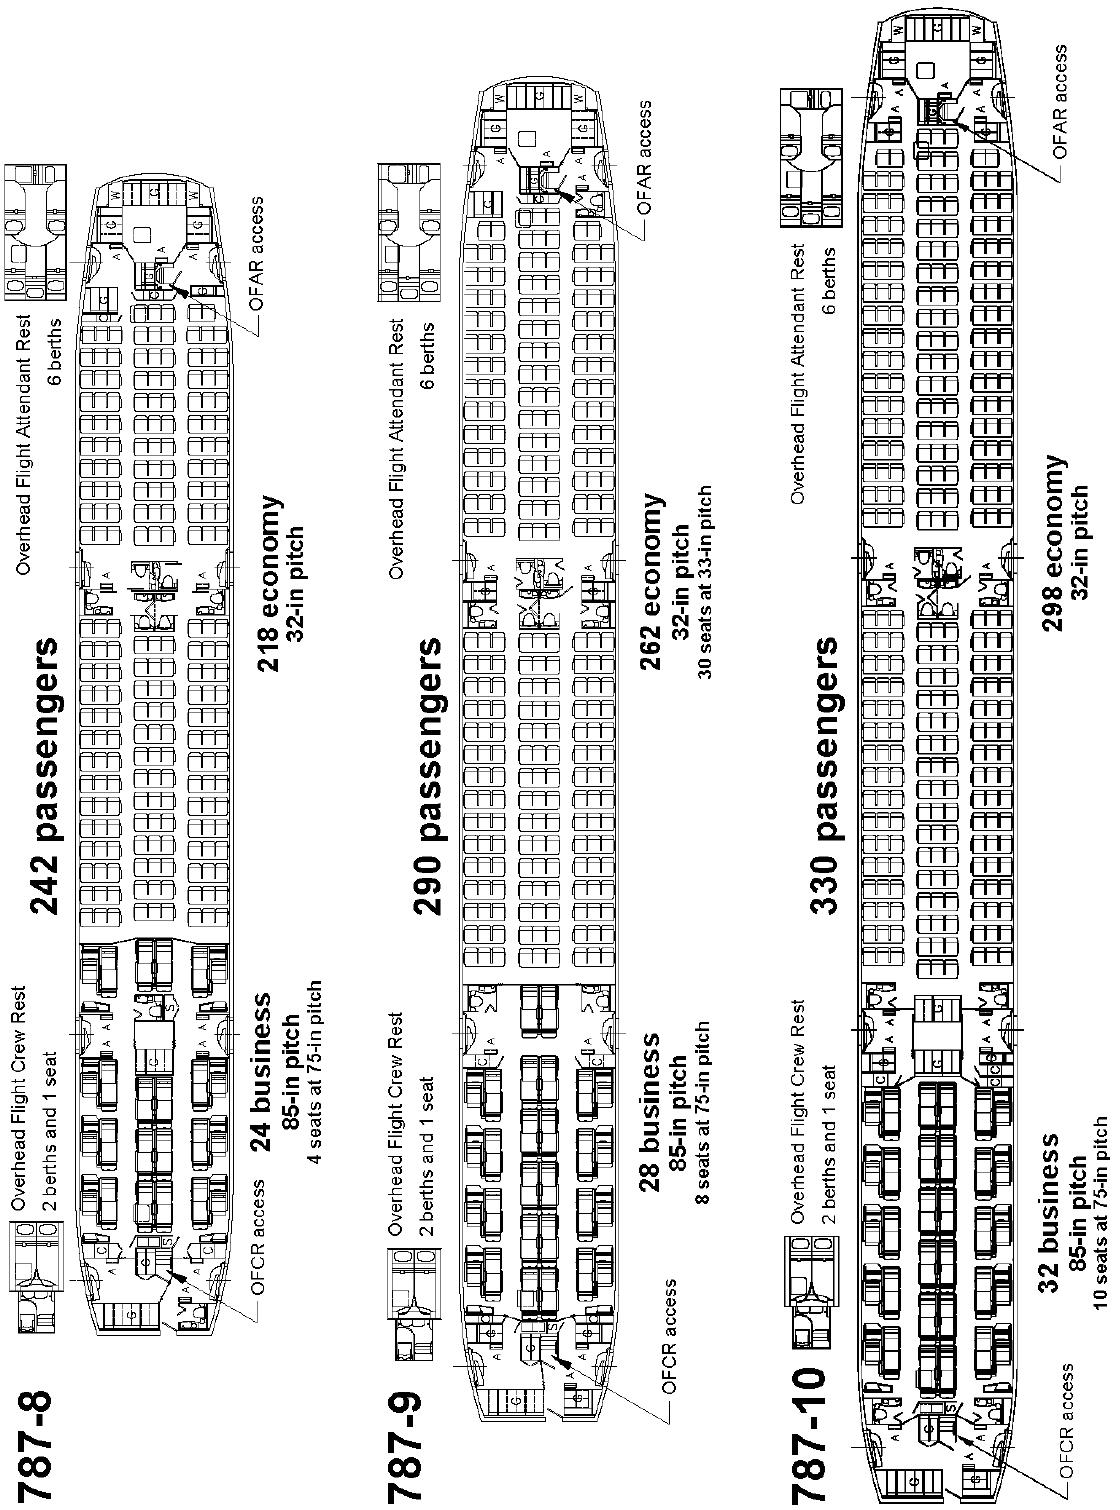

In [ ]:
from IPython.display import Image, Markdown, display

# List of source documents
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=10)

source_docs = split_image_text_types(docs)

for i in source_docs["images"]:
    display(Image(base64.b64decode(i)))

In [96]:
query = "Give me the general dimensions of model 787-8 in meters."

result = chain_multimodal_rag.invoke(query)

Markdown(result)

I am sorry, but the dimensions of the 787-8 are not mentioned in the text. I cannot answer the question.


In [ ]:
query = "Give me the general dimensions in meters of the aircraft: wingpsan, height, etcetera"

result = chain_multimodal_rag.invoke(query)

print(result)

Here are the dimensions for the Boeing 787-8 aircraft in meters:

From the images:

Wingspan: 197 ft 3 in (60.12 m)
Height: 55 ft 10 in (17.02 m)
Tail Height: 55 ft 10 in (17.02 m)
Fuselage Width: 19 ft 6 in (5.94 m)
Wheel Track: 32 ft 2 in (9.80 m)

From the text:

Maximum Design Taxi Weight (MTW)
Maximum Design Takeoff Weight (MTOW)
Maximum Design Landing Weight (MLW)
Maximum Design Zero Fuel Weight (MZFW)
Operating Empty Weight (OEW)
Maximum Structural Payload
Maximum Seating Capacity
Maximum Cargo Volume
Usable Fuel


[]


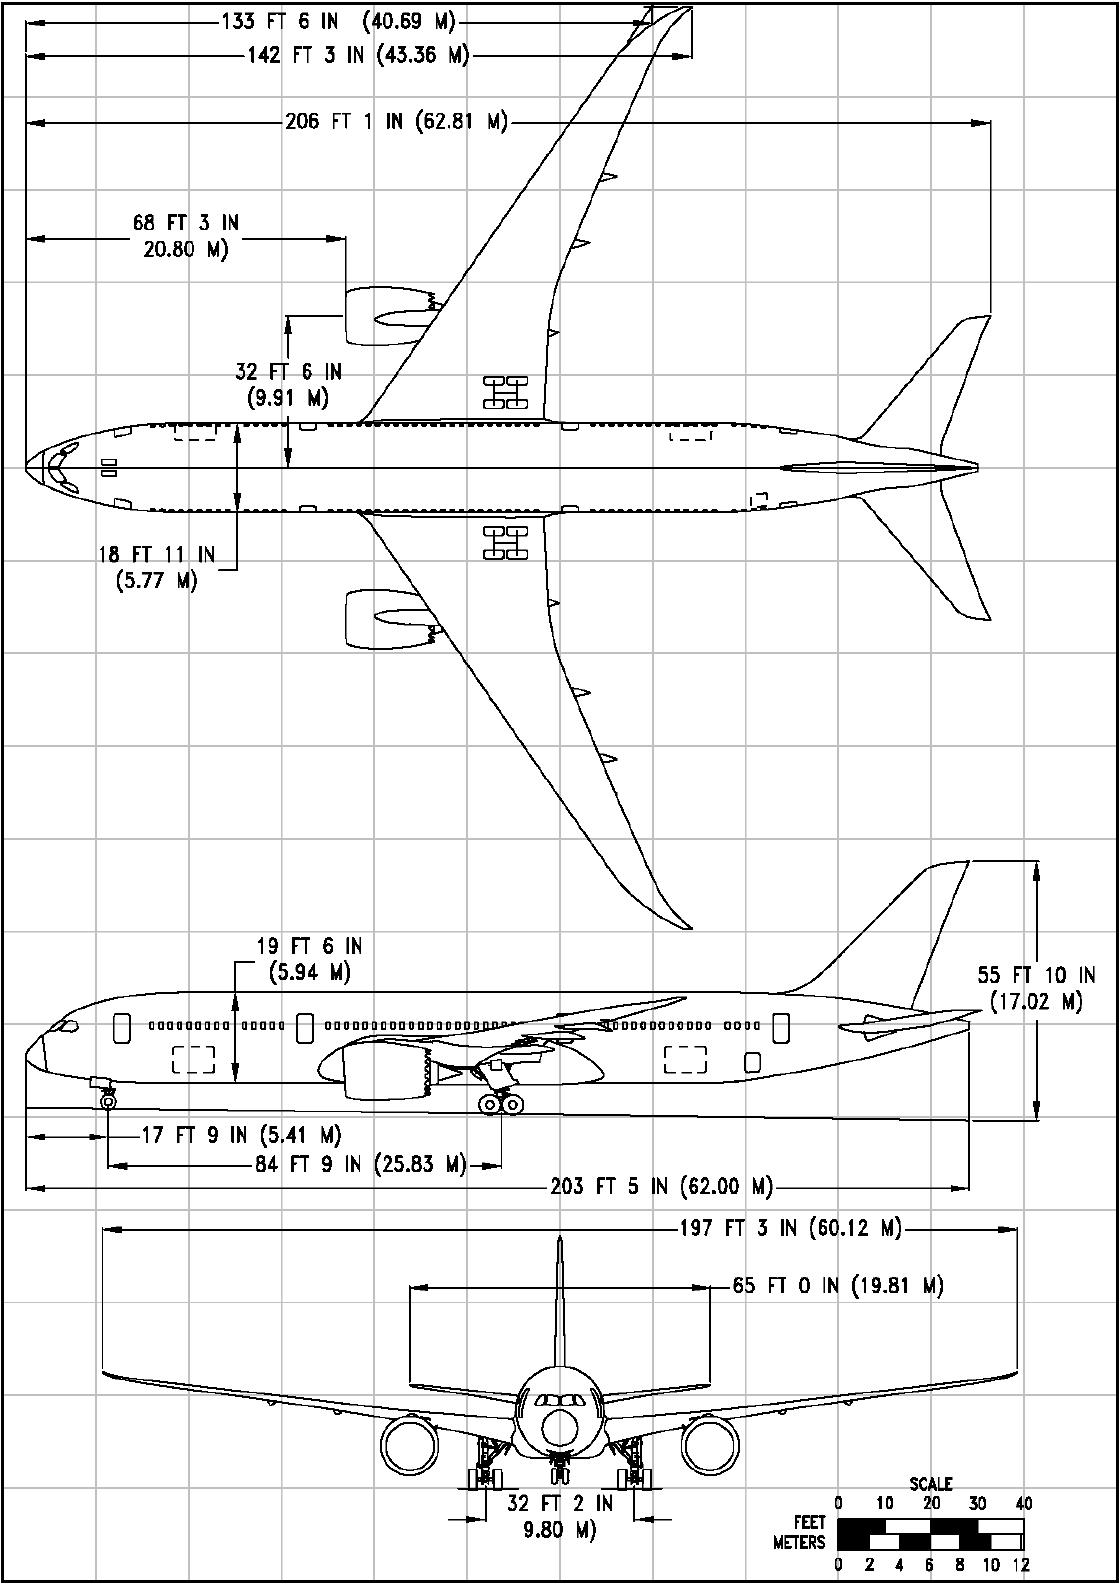

In [95]:
from IPython.display import Image, Markdown, display

# List of source documents
docs = retriever_multi_vector_img.get_relevant_documents(query, limit=10)

source_docs = split_image_text_types(docs)

print(source_docs["texts"])

for i in source_docs["images"]:
    display(Image(base64.b64decode(i)))